# OpenFoodfacts Ingredients Analysis

## Goal

Determine how many products have trustworthy ingredient information.

## Context

- Ingredient data is automatically extracted from ingredient photos.
- Products without ingredient photos have manually provided data and and are less reliable in terms of data completeness and correctness.
- Imported product data often lacks ingredient images, making its data quality uncertain.

## Data Extraction

The preferred method is to use a [data dump from OpenFoodFacts](https://world.openfoodfacts.org/data) to extract the necessary information.

Data extraction is performed using JQ and DuckDB, both of which are well-established tools. However, they have distinct strengths and weaknesses, particularly when processing large jsonl.gz files.

### Fields to Extract

- `code`
- `ingredients_n`
- `known_ingredients_n`
- `unknown_ingredients_n`
- `ingredients_percent_analysis`
- `images`
- `states_tags`
- `data_quality_info_tags`

### Encountered JSONL Data Issues

- Unexpected characters → Can cause issues in DuckDB.
- Mixed data types → Fields like *ingredients_n may contain values as integers, floats, strings (e.g., 1.0, 1, "1"), or even NaN, leading to inconsistencies.

### Extraction Requirements
To ensure consistent output between JQ and DuckDB, the following rules are applied:

- Convert all count values as integers.
- Filter all tag values for ingredient and store as comma-delimited strings.

## Code

### JQ

Note: jq automatically drops the fractional part of a number if it is `.0` (okay with JSON specs).

```
time (
  echo "code,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,images,states,quality_info"
  zcat < openfoodfacts-products.jsonl.gz | jq -r '[
    .code,
    (if .ingredients_n == null then null else .ingredients_n | tonumber end),
    (if .known_ingredients_n == null then null else .known_ingredients_n | tonumber end),
    (if .unknown_ingredients_n == null then null else .unknown_ingredients_n | tonumber end),
    (if .ingredients_analysis_tags != null then true else false end),
    .ingredients_percent_analysis,
    (.images // {} | to_entries | map(select(.key | startswith("ingred")) | .key) | if length > 0 then join(",") else null end),
    (.states_tags // [] | map(select(startswith("en:ingred"))) | if length > 0 then join(",") else null end),
    (.data_quality_info_tags // [] | map(select(startswith("en:ing"))) | if length > 0 then join(",") else null end)]
| @csv'
) >ingredients_data_export_jq.csv
```

### With DuckDB

CAUTION: DUCKDB has issues with .gz file and unexpected characters

- use `DISTINCT` to avoid duplicates due by duckdb's parallel processing of gz files.
- use `CAST(*, AS INTEGER)` to handle mixed types (NULL, integer, double, string).
- use `array_to_string` instead of `to_json` for serializing lists.
- use `read_ndjson(*, ignore_errors=True)` to handle unexpected characters.
- use `FORCE_QUOTE` for compatability with jq output.

```
COPY (
    SELECT DISTINCT
        code,
        CAST(ingredients_n AS INTEGER) AS ingredients_n,
        CAST(known_ingredients_n AS INTEGER) AS known_ingredients_n,
        CAST(unknown_ingredients_n AS INTEGER) AS unknown_ingredients_n,
        ingredients_analysis_tags IS NOT NULL AS has_analysis_tags,
        ingredients_percent_analysis,
        array_to_string(list_filter(json_keys(images), x -> x LIKE 'ingred%'), ',') AS images,
        array_to_string(list_filter(states_tags, x -> x LIKE 'en:ing%'), ',') as states,
        array_to_string(list_filter(data_quality_info_tags, x -> x LIKE 'en:ing%'), ',') as quality_info
    FROM read_ndjson('openfoodfacts-products.jsonl.gz', ignore_errors=True)
) TO 'ingredients_data_export_dd.csv' (FORMAT CSV, HEADER, FORCE_QUOTE (code, images, states, quality_info));
```

### Compare JQ with DuckDB output

Sort both csv files and then

`comm -2 -3 sorted_jq.csv sorted_dd.csv`

to identify any difference.

## Summary of Data Insights

### TL;TR

- 27.7% have at least one ingredient image
- 26.2% have `en:ingredients-photo-selected`

### Data Issues
- 63 duplicate barcodes + 2 empty barcodes
- 71.7% have missing ingredient statistics (`ingredients_n` etc.) / percent analysis.
- 72.3% have missing ingredient image(s).
- 70.0% have missing ingredient analysis. (no tag for `vegan`, `vegetarian`, `palm oil`).
- 73.9% don't have `en:ingredient_percent_analysis_ok` quality tag.
- 1.9% have `known_ingredients_n` = 0.
- 1.5% have an ingredients image but not state `en:ingredients-photo-selected`.
- 1% have more than 50 ingredients.

### Data Insights - Ingredients Images
- 27.7% have at least one ingredient image.
- 26.2% have `en:ingredients-photo-selected` / 1.5% without.
- 25.0% have ingredient image in fr, en, de, es.
- 15.8% have ingredient image in fr.

### Data Insights - State Tags 
- 28.1% have `en:ingredients-completed`.
- 26.2% have `en:ingredients-photo-selected`
- 16.0% have both `en:ingredients-completed` and `en:ingredients-photo-selected`.

### Data Insights - Analysis
- 26.0% have data quality tag `en:ingredients-percent-analysis-ok`.
- 10.2% have zero `unknown_ingredients_n`.
-  6.2% have ingredients image and zero `unknown_ingredients_n`.

## inconsistency in ingredient analysis
- 2.7% have known + unknown ingredients add up to `ingredients_n`.

## Data Quality Criteria
- ✅ `en:ingredients-photo-selected` (image exists & was selected) -> large subset of has ingredient image
- ✅ `en:ingredients-completed` (ingredient list is marked as finalized)
- ✅ `en:ingredients-percent-analysis-ok` (percent breakdown is validated) -> (almost) large subset of completed
- ✅ `unknown_ingredients_n` = 0 (no unknown ingredients present) -> can relax with <=2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [2]:
!wc -l ../data/ingredients_data_export_jq.csv

 3671229 ../data/ingredients_data_export_jq.csv


In [3]:
%%time
file_path = "../data/ingredients_data_export_jq.csv"
df = pd.read_csv(file_path, dtype={'code':str, 'ingredients_n': str})
df = df[df.code.notna()] # exclude empty barcodes

# use int for counts
for col in ['ingredients_n', 'known_ingredients_n', 'unknown_ingredients_n', 'ingredients_percent_analysis']:
    df[col] = df[col].astype('Int64')

display(df)

,code,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,images,states,quality_info
0,0000101209159,<NA>,<NA>,<NA>,False,<NA>,ingredients_fr,"en:ingredients-to-be-completed,en:ingredients-...",NaN
1,0000105000011,1,3,0,True,1,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
2,0000105000042,1,3,0,True,1,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
3,0000105000059,1,0,1,True,1,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
4,0000105000073,1,2,0,True,1,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
...,...,...,...,...,...,...,...,...,...
3671223,8854545889857,<NA>,<NA>,<NA>,False,<NA>,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3671224,8854545889840,<NA>,<NA>,<NA>,False,<NA>,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3671225,8854545889925,<NA>,<NA>,<NA>,False,<NA>,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3671226,8854545889871,<NA>,<NA>,<NA>,False,<NA>,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN


CPU times: user 3.45 s, sys: 378 ms, total: 3.82 s
Wall time: 3.89 s


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3671226 entries, 0 to 3671227
Data columns (total 9 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   code                          object
 1   ingredients_n                 Int64 
 2   known_ingredients_n           Int64 
 3   unknown_ingredients_n         Int64 
 4   has_analysis_tags             bool  
 5   ingredients_percent_analysis  Int64 
 6   images                        object
 7   states                        object
 8   quality_info                  object
dtypes: Int64(4), bool(1), object(4)
memory usage: 269.6+ MB


## Duplicate Rows

In [5]:
df.code.value_counts()[lambda x: x > 1]

code
4001638098182         2
516408508322002749    2
0059527501552         2
0059527401555         2
3760310820145         2
                     ..
3856003909850         2
8002924312636         2
3770008983205         2
7798049540559         2
8424465929072         2
Name: count, Length: 63, dtype: int64

## EDA

In [6]:
!pip install ydata-profiling -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Analyzing ingredients

In [8]:
(df.ingredients_n == 0).value_counts()

ingredients_n
False    1038077
True        2121
Name: count, dtype: Int64

In [9]:
# products with a count for unknown ingredients
len(df.unknown_ingredients_n[lambda x: x.notna()])

1040815

In [10]:
# products with a count for unknown ingredients
(len(df.unknown_ingredients_n[lambda x: x.notna()])) / len(df)

0.2835061094032348

In [11]:
# good products with 0 unknown ingredients
len(df.unknown_ingredients_n[lambda x: x == 0])

374832

In [12]:
# percentage of good products with 0 unknown ingredients
len(df.unknown_ingredients_n[lambda x: x == 0]) / len(df)

0.1020999524409557

In [13]:
# products with at least one unknown ingredient
len(df.unknown_ingredients_n[lambda x: x > 0])

665983

### Does known + unknown ingredients add up?

In [14]:
# add and compare with ingredient count
match = df.known_ingredients_n + df.unknown_ingredients_n == df.ingredients_n
match.value_counts(dropna=False)

<NA>     2631142
False     940323
True       99761
Name: count, dtype: Int64

In [15]:
# percentages total
match.value_counts(dropna=False) / len(df)

<NA>     0.716693
False    0.256133
True     0.027174
Name: count, dtype: Float64

In [16]:
# percentages for prodcut with ingredients_n
match.value_counts(dropna=True) / len(df.ingredients_n[df.ingredients_n.notna()])

False    0.903985
True     0.095906
Name: count, dtype: Float64

In [17]:
# good products have image and unknown ingredients = 0
len(df[lambda x: (df.images.notna() & (df.unknown_ingredients_n == 0))]) / len(df)

0.062091791679400835

## Plotting Data

In [18]:
%matplotlib inline

<Axes: xlabel='ingredients_n'>

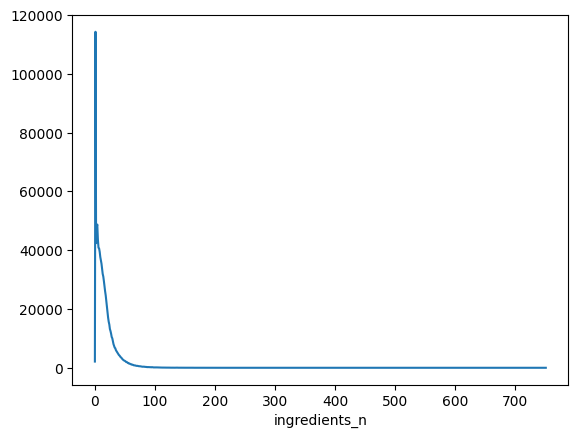

In [19]:
df.ingredients_n.value_counts().sort_index().plot()

<Axes: xlabel='known_ingredients_n'>

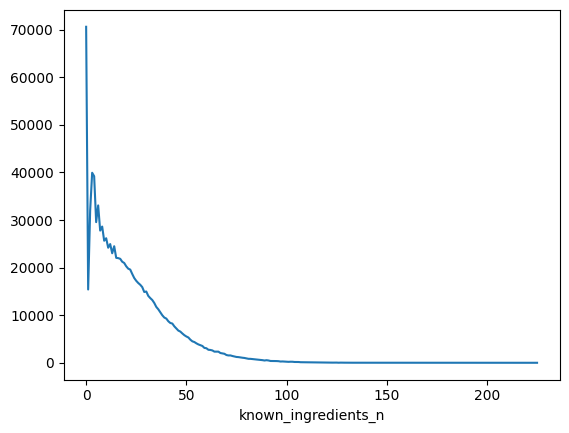

In [20]:
df.known_ingredients_n.value_counts().sort_index().plot()

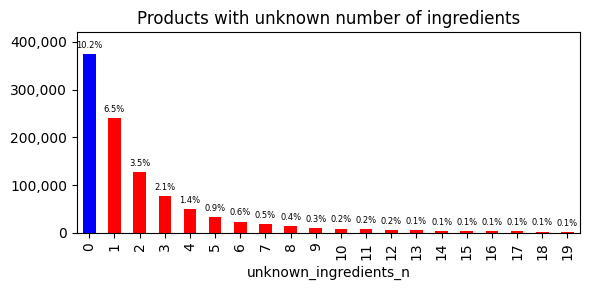

In [21]:
from matplotlib.ticker import FuncFormatter

dfx = df.unknown_ingredients_n.value_counts().sort_index()
dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['blue' if idx == 0 else 'red' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 420000)
plt.title("Products with unknown number of ingredients")
plt.tight_layout();
plt.savefig("unknown_number_ingredients.png");

In [22]:
# products with more than 50 ingredients
"{:.2%}".format(len(df[df.ingredients_n > 50]) / len(df))

'1.04%'

## Tag Analysis

### Ingredients Images

In [23]:
# products with ingredients image(s)
df_images = df.images[lambda x: x.notna()]
print(len(df_images))
print("{:.1%}".format(len(df_images) / len(df)))

1017439
27.7%


In [24]:
(df.images.value_counts(dropna=False) / len(df)).map("{:.1%}".format)

images
NaN                                                            72.3%
ingredients_fr                                                 13.3%
ingredients_en                                                  4.5%
ingredients_de                                                  2.2%
ingredients_es                                                  1.7%
                                                               ...  
ingredients_he,ingredients_fr,ingredients                       0.0%
ingredients_he,ingredients                                      0.0%
ingredients_he,ingredients,ingredients_ar                       0.0%
ingredients_es,ingredients_cs,ingredients_it,ingredients_ro     0.0%
ingredients_fr,ingredients_it,ingredients_gl                    0.0%
Name: count, Length: 5478, dtype: object

In [25]:
# number of ingredient images per product
(df_images.str.split(',').map(len).value_counts().sort_index() / len(df)).map("{:.1%}".format)

images
1     24.4%
2      2.9%
3      0.3%
4      0.1%
5      0.0%
6      0.0%
7      0.0%
8      0.0%
9      0.0%
10     0.0%
11     0.0%
12     0.0%
13     0.0%
14     0.0%
15     0.0%
16     0.0%
17     0.0%
19     0.0%
20     0.0%
21     0.0%
22     0.0%
23     0.0%
25     0.0%
Name: count, dtype: object

In [26]:
(df_images.str.split(',').explode().map(str.lower).value_counts().head(10) / len(df)).map("{:.1%}".format)

images
ingredients_fr    15.8%
ingredients_en     5.8%
ingredients_de     2.9%
ingredients_es     2.1%
ingredients        1.3%
ingredients_it     0.8%
ingredients_nl     0.5%
ingredients_pt     0.3%
ingredients_pl     0.3%
ingredients_ro     0.2%
Name: count, dtype: object

In [27]:
top_lc = ['ingredients_fr', 'ingredients_en', 'ingredients_de', 'ingredients_es']
(df_images.str.split(',').map(lambda x: any([lc in x for lc in top_lc])).value_counts(dropna=False) / len(df)).map("{:.1%}".format)

images
True     25.0%
False     2.7%
Name: count, dtype: object

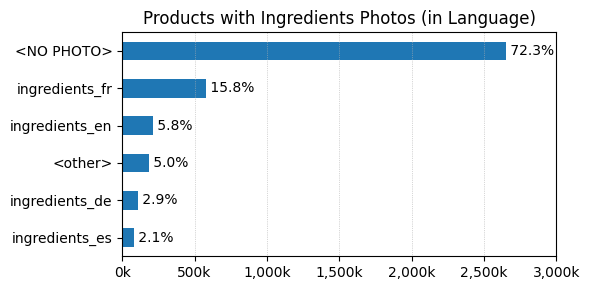

In [28]:
import matplotlib.ticker as mtick

top_images = df.images.str.split(',').explode().map(lambda x: "<NO PHOTO>" if pd.isna(x) else x if x in top_lc else "<other>").value_counts(dropna=False)
ax = top_images[::-1].plot.barh(figsize=(6,3))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y/1000):,}k'))
ax.grid(axis='x', linestyle=':', linewidth=0.5)
ax.set_ylabel(None)
ax.set_xlim(0.0, 3000000)
# Annotate each bar with its value outside the bar on the right side
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width / len(df) * 100:.1f}%', va='center', ha='left')
plt.title("Products with Ingredients Photos (in Language)");
plt.tight_layout()
plt.savefig("with_ingredients_photo_in_lc.png")

In [29]:
!pip install matplotlib_venn -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


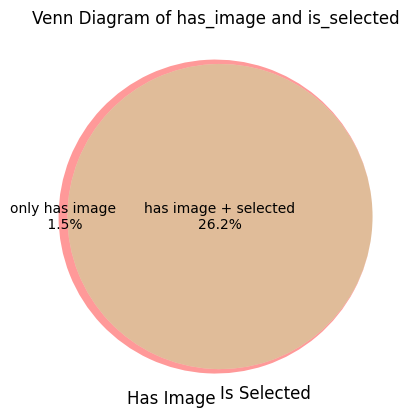

In [30]:
from matplotlib_venn import venn2

has_image = df.images.notna()
is_photo_selected = df.states.str.contains('en:ingredients-photo-selected')

# Calculate counts
only_has_image = (has_image & ~is_photo_selected).sum()
only_is_selected = (~has_image & is_photo_selected).sum()
both = (has_image & is_photo_selected).sum()

# Create Venn diagram
venn = venn2(subsets=(only_has_image, only_is_selected, both), set_labels=('Has Image', 'Is Selected'))
plt.title("Venn Diagram of has_image and is_selected")

# Replace the subset labels with percentages
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text("only has image\n {:.1f}%".format(only_has_image / len(df) * 100))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text("")
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text("has image + selected\n{:.1f}%".format(both / len(df) * 100))

plt.show()

### States

In [31]:
df.states.value_counts(dropna=False)

states
en:ingredients-to-be-completed,en:ingredients-photo-to-be-selected    1799098
en:ingredients-completed,en:ingredients-photo-selected                 587426
en:ingredients-to-be-completed                                         467748
en:ingredients-to-be-completed,en:ingredients-photo-selected           373615
en:ingredients-completed                                               273524
en:ingredients-completed,en:ingredients-photo-to-be-selected           169815
Name: count, dtype: int64

In [32]:
(df.states.value_counts(dropna=False) / len(df)).map("{:.1%}".format)

states
en:ingredients-to-be-completed,en:ingredients-photo-to-be-selected    49.0%
en:ingredients-completed,en:ingredients-photo-selected                16.0%
en:ingredients-to-be-completed                                        12.7%
en:ingredients-to-be-completed,en:ingredients-photo-selected          10.2%
en:ingredients-completed                                               7.5%
en:ingredients-completed,en:ingredients-photo-to-be-selected           4.6%
Name: count, dtype: object

In [33]:
df.states.str.split(',').explode().value_counts()

states
en:ingredients-to-be-completed         2640461
en:ingredients-photo-to-be-selected    1968913
en:ingredients-completed               1030765
en:ingredients-photo-selected           961041
Name: count, dtype: int64

In [34]:
(df.states.str.split(',').explode().value_counts() / len(df)).map("{:.1%}".format)

states
en:ingredients-to-be-completed         71.9%
en:ingredients-photo-to-be-selected    53.6%
en:ingredients-completed               28.1%
en:ingredients-photo-selected          26.2%
Name: count, dtype: object

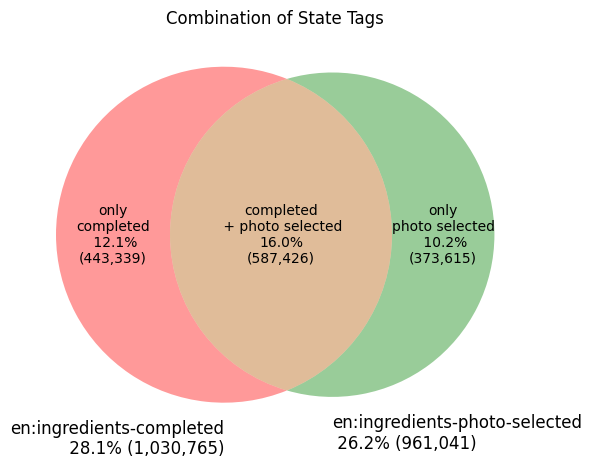

In [35]:
from matplotlib_venn import venn2

is_completed = df.states.str.contains('en:ingredients-completed')
is_photo_selected = df.states.str.contains('en:ingredients-photo-selected')

# Calculate counts
only_completed = (is_completed & ~is_photo_selected).sum()
only_selected = (~is_completed & is_photo_selected).sum()
both = (is_completed & is_photo_selected).sum()

# Create Venn diagram
venn = venn2(subsets=(only_completed, only_selected, both), set_labels=('en:ingredients-completed\n {:.1f}% ({:,})'.format(is_completed.sum() / len(df) *100, is_completed.sum()), 'en:ingredients-photo-selected\n {:.1f}% ({:,})'.format(is_photo_selected.sum() / len(df) * 100,is_photo_selected.sum())))
plt.title("Combination of State Tags")

# Replace the subset labels with percentages
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text("only\ncompleted\n {:.1f}%\n({:,})".format(only_completed / len(df) * 100, only_completed))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text("only\nphoto selected\n {:.1f}%\n({:,})".format(only_selected / len(df) * 100, only_selected))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text("completed\n + photo selected\n{:.1f}%\n({:,})".format(both / len(df) * 100, both))

plt.tight_layout()
plt.savefig("venn_completed_selected.png");
plt.show()

In [36]:
df.quality_info.notna().sum()

957113

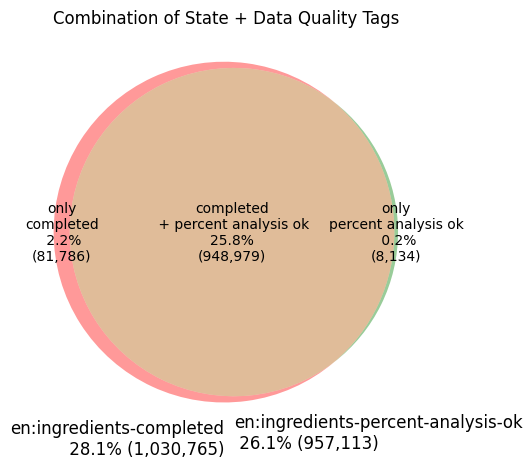

In [37]:
from matplotlib_venn import venn2

is_completed = df.states.str.contains('en:ingredients-completed')
is_analysis_ok = df.quality_info.notna()

# Calculate counts
only_completed = (is_completed & ~is_analysis_ok).sum()
only_analysis_ok = (~is_completed & is_analysis_ok).sum()
both = (is_completed & is_analysis_ok).sum()

# Create Venn diagram
venn = venn2(subsets=(only_completed, only_analysis_ok, both), set_labels=('en:ingredients-completed\n {:.1f}% ({:,})'.format(is_completed.sum() / len(df) *100, is_completed.sum()), 'en:ingredients-percent-analysis-ok\n {:.1f}% ({:,})'.format(is_analysis_ok.sum() / len(df) * 100,is_analysis_ok.sum())))
plt.title("Combination of State + Data Quality Tags")

# Replace the subset labels with percentages
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text("only\ncompleted\n {:.1f}%\n({:,})".format(only_completed / len(df) * 100, only_completed))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text("only\npercent analysis ok\n {:.1f}%\n({:,})".format(only_analysis_ok / len(df) * 100, only_analysis_ok))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text("completed\n + percent analysis ok\n{:.1f}%\n({:,})".format(both / len(df) * 100, both))

plt.tight_layout()
plt.savefig("venn_completed_selected.png");
plt.show()

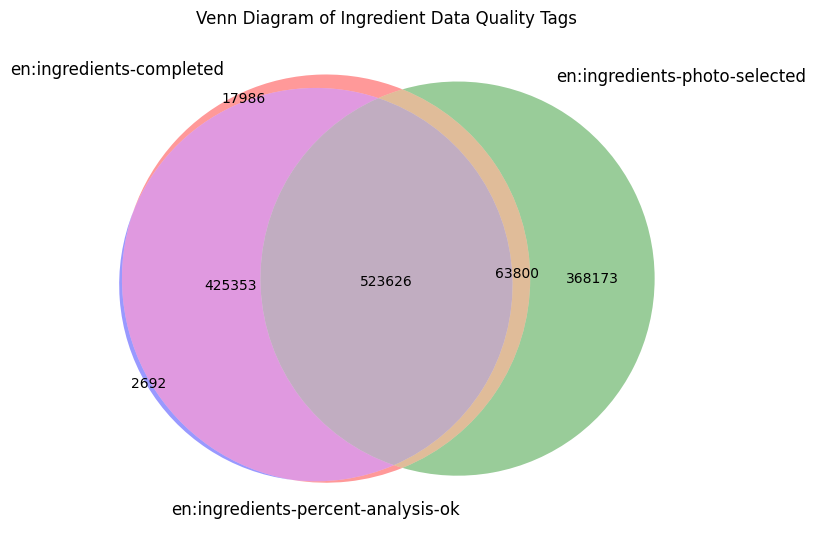

In [38]:
from matplotlib_venn import venn3

is_completed = df[df.states.str.contains('en:ingredients-completed')].index
is_photo_selected = df[df.states.str.contains('en:ingredients-photo-selected')].index
is_analysis_ok = df[df.quality_info.notna()].index

plt.figure(figsize=(8, 8))
venn3(
    [set(is_completed), set(is_photo_selected), set(is_analysis_ok)],
    set_labels=('en:ingredients-completed', 'en:ingredients-photo-selected', 'en:ingredients-percent-analysis-ok')
)
plt.title("Venn Diagram of Ingredient Data Quality Tags")
plt.show()

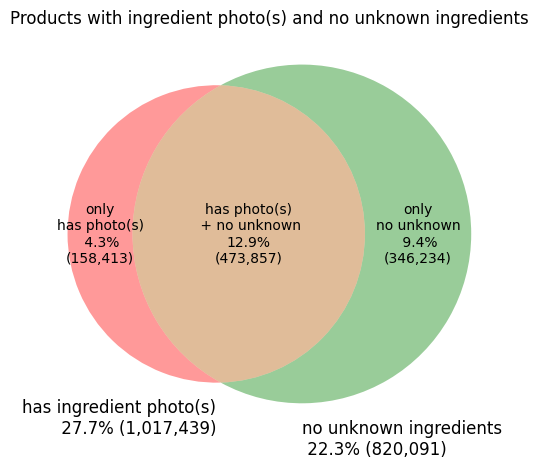

In [39]:
from matplotlib_venn import venn2

has_image = df.images.notna()
no_unknown = df.unknown_ingredients_n <= 3

# Calculate counts
only_has_image = (has_image & ~no_unknown).sum()
only_no_unknown = (~has_image & no_unknown).sum()
both = (has_image & no_unknown).sum()

# Create Venn diagram
venn = venn2(subsets=(only_has_image, only_no_unknown, both), set_labels=('has ingredient photo(s)\n {:.1f}% ({:,})'.format(has_image.sum() / len(df) *100, has_image.sum()), 'no unknown ingredients\n {:.1f}% ({:,})'.format(no_unknown.sum() / len(df) *100, no_unknown.sum())))
plt.title("Products with ingredient photo(s) and no unknown ingredients")

# Replace the subset labels with percentages
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text("only\nhas photo(s)\n {:.1f}%\n({:,})".format(only_has_image / len(df) * 100, only_has_image))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text("only\nno unknown\n {:.1f}%\n({:,})".format(only_no_unknown / len(df) * 100, only_no_unknown))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text("has photo(s)\n + no unknown\n{:.1f}%\n({:,})".format(both / len(df) * 100, both))

plt.tight_layout()
plt.savefig("venn_image_no_unknown.png");
plt.show()

In [40]:
both / len(df_images)

0.46573504652367365

### Quality info

In [41]:
df.quality_info.value_counts(dropna=False)# / len(df)

quality_info
NaN                                   2714113
en:ingredients-percent-analysis-ok     957113
Name: count, dtype: int64

## States

In [42]:
df_states = df.states.str.get_dummies(sep=',')
df_states

,en:ingredients-completed,en:ingredients-photo-selected,en:ingredients-photo-to-be-selected,en:ingredients-to-be-completed
0,0,1,0,1
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
3671223,0,0,1,1
3671224,0,0,1,1
3671225,0,0,1,1
3671226,0,0,1,1


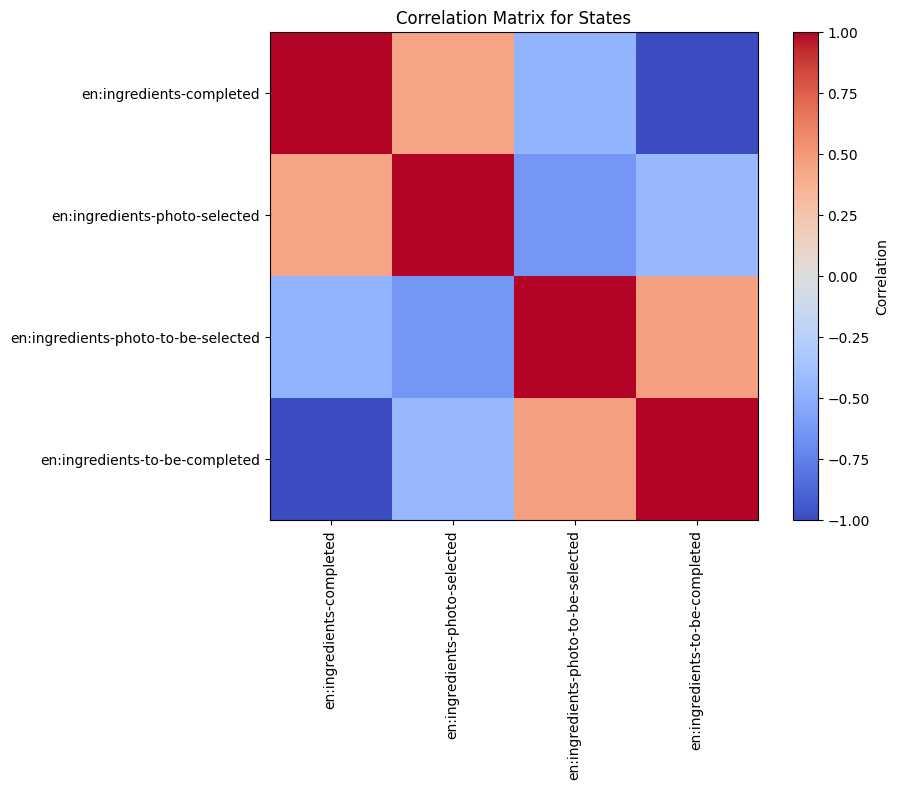

In [43]:
%matplotlib inline
df_bool_int = df_states.astype(int)

# Compute the correlation matrix
corr_matrix = df_bool_int.corr()

# Plot using matplotlib's imshow
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')

# Set tick labels for both axes
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)

plt.title('Correlation Matrix for States')
plt.tight_layout()
plt.show()

In [44]:
len(df[df.images.notna() & df.states.str.contains("en:ingredients-photo-selected")]) / len(df)

0.26177658362628725

In [45]:
# ingredients image but not state set
len(df[df.images.notna() & ~df.states.str.contains("en:ingredients-photo-selected")]) / len(df)

0.015362170566453823

In [46]:
len(df[df.quality_info.notna() & df.states.str.contains("en:ingredients-photo-selected")]) / len(df)

0.14411207591142577

In [47]:
len(df[df.images.notna() & df.quality_info.notna()]) / len(df)

0.15277839065206011

# Trusted Products

In [48]:
df_trusted = df[df.states.str.contains('en:ingredients-completed') &
    df.states.str.contains('en:ingredients-photo-selected') &
    df.quality_info.notna()]

In [49]:
print(len(df_trusted))
len(df_trusted) / len(df)

523626


0.14262973731391093

In [50]:
df_trusted.images.str.split(',').explode().value_counts(dropna=False).head(15)

images
ingredients_fr    259119
ingredients_en    137323
ingredients_de     78285
ingredients        40070
ingredients_es     35476
ingredients_it     19730
ingredients_nl     14784
ingredients_pt      7609
ingredients_pl      6822
ingredients_sv      5209
ingredients_bg      3538
ingredients_nb      3529
ingredients_fi      3496
ingredients_ru      3253
ingredients_cs      3028
Name: count, dtype: int64

In [51]:
df_trusted.unknown_ingredients_n.value_counts(dropna=False)

unknown_ingredients_n
0       209423
1       115522
2        57543
3        34301
4        22762
         ...  
140          1
119          1
128          1
158          1
<NA>         0
Name: count, Length: 155, dtype: Int64

In [52]:
df_trusted.has_analysis_tags.value_counts(dropna=False)

has_analysis_tags
True     522528
False      1098
Name: count, dtype: int64

In [53]:
df_trusted.ingredients_percent_analysis.value_counts(dropna=False)

ingredients_percent_analysis
1       523582
<NA>        44
Name: count, dtype: Int64

In [54]:
df_trusted.states.value_counts(dropna=False)

states
en:ingredients-completed,en:ingredients-photo-selected    523626
Name: count, dtype: int64

In [55]:
df_trusted.quality_info.value_counts(dropna=False)

quality_info
en:ingredients-percent-analysis-ok    523626
Name: count, dtype: int64

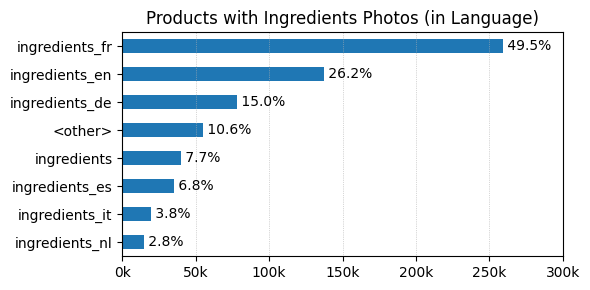

In [56]:
top_lc = ['ingredients_fr', 'ingredients_en', 'ingredients_de', 'ingredients', 'ingredients_es', 'ingredients_it', 'ingredients_nl']
top_images = df_trusted.images.str.split(',').explode().map(lambda x: "<NO PHOTO>" if pd.isna(x) else x if x in top_lc else "<other>").value_counts(dropna=False)
ax = top_images[::-1].plot.barh(figsize=(6,3))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y/1000):,}k'))
ax.grid(axis='x', linestyle=':', linewidth=0.5)
ax.set_ylabel(None)
ax.set_xlim(0.0, 300000)
# Annotate each bar with its value outside the bar on the right side
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width / len(df_trusted) * 100:.1f}%', va='center', ha='left')
plt.title("Products with Ingredients Photos (in Language)");
plt.tight_layout()

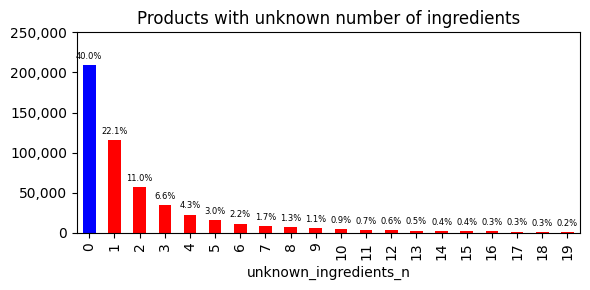

In [57]:
from matplotlib.ticker import FuncFormatter

dfx = df_trusted.unknown_ingredients_n.value_counts().sort_index()
dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['blue' if idx == 0 else 'red' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_trusted) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 250000)
plt.title("Products with unknown number of ingredients")
plt.tight_layout();

# Only Known Ingredients

In [58]:
df_known = df_trusted[df_trusted.unknown_ingredients_n == 0]
len(df_known)

209423

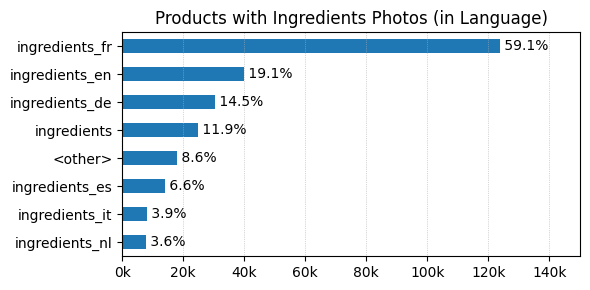

In [59]:
top_images = df_known.images.str.split(',').explode().map(lambda x: "<NO PHOTO>" if pd.isna(x) else x if x in top_lc else "<other>").value_counts(dropna=False)
ax = top_images[::-1].plot.barh(figsize=(6,3))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y/1000):,}k'))
ax.grid(axis='x', linestyle=':', linewidth=0.5)
ax.set_ylabel(None)
ax.set_xlim(0.0, 150000)
# Annotate each bar with its value outside the bar on the right side
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width / len(df_known) * 100:.1f}%', va='center', ha='left')
plt.title("Products with Ingredients Photos (in Language)");
plt.tight_layout()